### 3. Modelling/Prediction
This section will handle objects 2 and 3 by (1) Use K-means clustering to segment employees into risk regimes (Low/Moderate/High/Critical) based on patterns in the data, with optimal K determined through elbow and silhouette validation, and (2) employing binary classification to predict individual attrition probability

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
import os 
os.getcwd() #find working directory to locate csv 

'/Users/macbook/Documents/employee-attrition'

#### 3.1 Load the data

In [9]:
# View the first five rows
df =pd.read_csv('data/processed_attrition_dataset.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [17]:
# get the dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

#### 3.2 ML Pipeline for Cluster
Identify categorical and numerical columns for proper column transformers creation

#### Categorical columns 
- binary_cols = Gender, OverTime
- ordinal_cols = 'BusinessTravel', 'Education', 'EnvironmentSatisfaction',
                'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
                'PerformanceRating', 'RelationshipSatisfaction',
                'StockOptionLevel', 'WorkLifeBalance'
- nominal_cols = 'Department', 'EducationField', 'JobRole', 'MaritalStatus'
- #### For now, we leave an arbitrary value of 31 (number of rows, but will be updated later) as the values of n_components of PCA and n_clusters of KMeans.
- #### i) The Cluster pipeline

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def PipelineCluster():
      # Binary columns
    binary_cols = ['Attrition', 'Gender', 'OverTime']
    
    # Ordinal columns
    ordinal_cols = [
        'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
        'JobLevel', 'JobSatisfaction', 'PerformanceRating',
        'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
    ]
    
    # Nominal columns
    nominal_cols = [
        'BusinessTravel', 'Department', 'EducationField',
        'JobRole', 'MaritalStatus'
    ]
    
    # Numeric columns
    numeric_cols = [
        'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
        'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'
    ]
    
    # Create transformers for each type
    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    ordinal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Combine all transformers
    preprocessor = ColumnTransformer([
        ('binary', binary_transformer, binary_cols),    # 2 categories
        ('ordinal', ordinal_transformer, ordinal_cols), # Ordered categories
        ('nominal', nominal_transformer, nominal_cols), # Unordered categories
        ('numeric', numeric_transformer, numeric_cols)
    ])
    
    pipeline_base = Pipeline([
        ('preprocessor', preprocessor),  # Changed from 'column_transformer'
        ("PCA", PCA(n_components=31, random_state=0)), 
        ("model", KMeans(n_clusters=31, random_state=0)), 
    ])
    return pipeline_base

PipelineCluster()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Attrition', 'Gender',
                                                   'OverTime']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Education',
                                                   'EnvironmentSatisfa...
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('PCA', PCA(n_components=31, random_state=0)),
                ('model', KMeans(n_clusters=31, random_state=0))])

#### ii) determining suitable n_components for PCA

In [27]:
# Create a new pipeline containing all steps except two, apply to transform the data 
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))

(1470, 50) 
 <class 'numpy.ndarray'>


In [29]:
# Apply PCA separately to the scaled data
# Note: PCA implementation approach adapted from [Code Institute] Apply K-means Clustering
# Original reference: [Data Analysis and AI Bootcamp/2026]

n_components = 50 # set the number of components as all columns in the data

pca = PCA(n_components=n_components).fit(df_pca)  # set PCA object and fit to the data
x_PCA = pca.transform(df_pca) # array with transformed PCA


# the PCA object has .explained_variance_ratio_ attribute, which tells 
# how much information (variance) each component has 
# We store that to a DataFrame relating each component to its variance explanation
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# prints how much of the dataset these components explain (naturally in this case will be 100%)
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 50 components explain 100.0% of the data 

              Explained Variance Ratio (%)
Component 0                         19.181
Component 1                          7.248
Component 2                          4.999
Component 3                          4.930
Component 4                          4.642
Component 5                          4.419
Component 6                          4.262
Component 7                          4.202
Component 8                          4.049
Component 9                          3.872
Component 10                         3.680
Component 11                         3.649
Component 12                         3.386
Component 13                         3.128
Component 14                         2.595
Component 15                         2.152
Component 16                         2.075
Component 17                         1.937
Component 18                         1.907
Component 19                         1.406
Component 20                         1.381
Compo

* 50 components explain 100.0 % of the data
* 85%-92% is ideal for, so we pick 21 components to get slightly within 90% data variance

In [30]:
# Note: PCA implementation approach adapted from [Code Institute] Apply K-means Clustering
# Original reference: [Data Analysis and AI Bootcamp/2026]
n_components = 21

pca = PCA(n_components=n_components).fit(df_pca)
x_PCA = pca.transform(df_pca)

ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 21 components explain 89.1% of the data 

              Explained Variance Ratio (%)
Component 0                         19.181
Component 1                          7.248
Component 2                          4.999
Component 3                          4.930
Component 4                          4.642
Component 5                          4.419
Component 6                          4.262
Component 7                          4.202
Component 8                          4.049
Component 9                          3.872
Component 10                         3.680
Component 11                         3.649
Component 12                         3.386
Component 13                         3.128
Component 14                         2.595
Component 15                         2.152
Component 16                         2.075
Component 17                         1.937
Component 18                         1.907
Component 19                         1.406
Component 20                         1.381


* For almost 90% variance: 21 components (89.10%)
### 21 is taken as PCA n component

In [32]:
# Note: PCA implementation approach adapted from [Code Institute] Apply K-means Clustering
# Original reference: [Data Analysis and AI Bootcamp/2026]
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def PipelineCluster():
      # Binary columns
    binary_cols = ['Attrition', 'Gender', 'OverTime']
    
    # Ordinal columns
    ordinal_cols = [
        'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
        'JobLevel', 'JobSatisfaction', 'PerformanceRating',
        'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
    ]
    
    # Nominal columns
    nominal_cols = [
        'BusinessTravel', 'Department', 'EducationField',
        'JobRole', 'MaritalStatus'
    ]
    
    # Numeric columns
    numeric_cols = [
        'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
        'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'
    ]
    
    # Create transformers for each type
    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    ordinal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Combine all transformers
    preprocessor = ColumnTransformer([
        ('binary', binary_transformer, binary_cols),    # 2 categories
        ('ordinal', ordinal_transformer, ordinal_cols), # Ordered categories
        ('nominal', nominal_transformer, nominal_cols), # Unordered categories
        ('numeric', numeric_transformer, numeric_cols)
    ])
    
    pipeline_base = Pipeline([
        ('preprocessor', preprocessor),  # Changed from 'column_transformer'
        ("PCA", PCA(n_components=21, random_state=0)), 
        ("model", KMeans(n_clusters=31, random_state=0)), 
    ])
    return pipeline_base

PipelineCluster()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Attrition', 'Gender',
                                                   'OverTime']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Education',
                                                   'EnvironmentSatisfa...
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('PCA', PCA(n_components=21, random_state=0)),
                ('model', KMeans(n_clusters=31, random_state=0))])

#### iii) Elbow method and Silhouette score
Prepare data by removing the last step (.steps[:-1]) and fit_transform pipeline_analysis to the data

In [33]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
(1470, 21) 
 <class 'numpy.ndarray'>


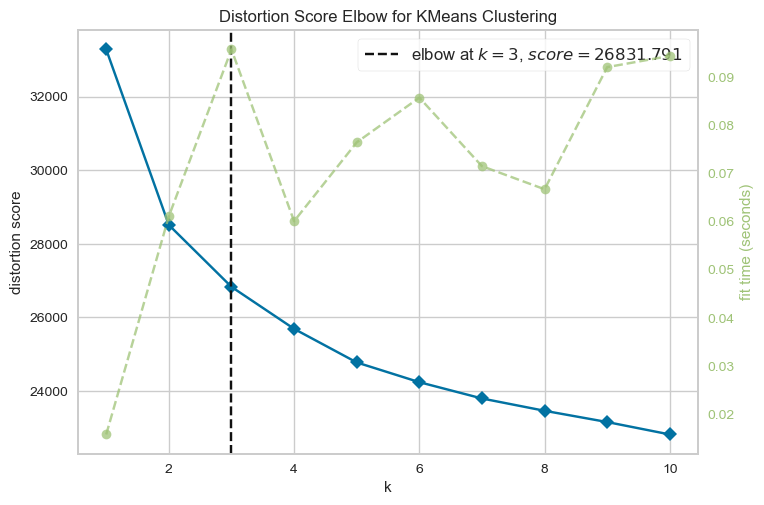

In [37]:
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

#### iv) Silhouette score
This will help to interpret and validate the consistency within clusters

=== Average Silhouette Score for different number of clusters ===


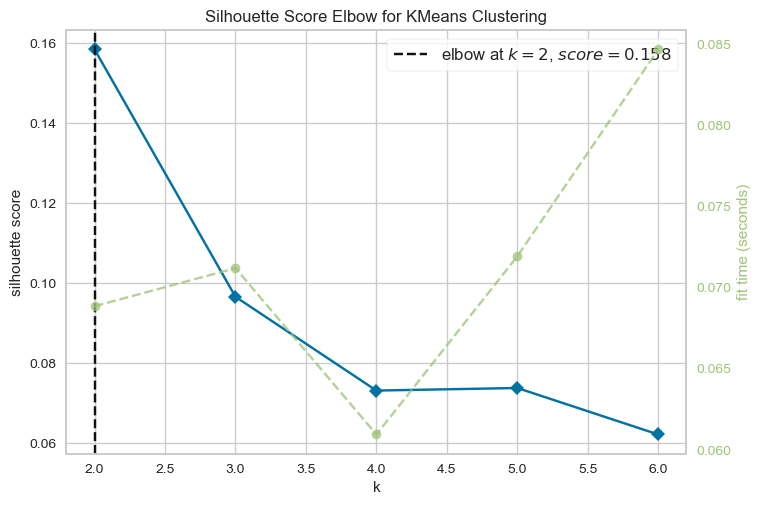



=== Silhouette plot for 2 Clusters ===


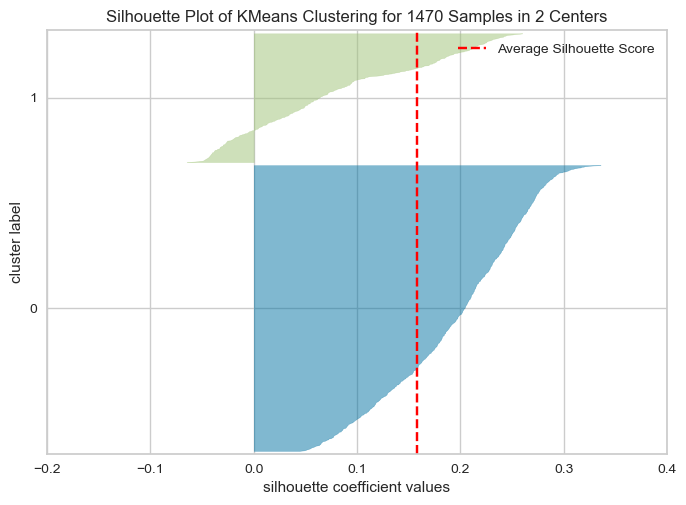



=== Silhouette plot for 3 Clusters ===


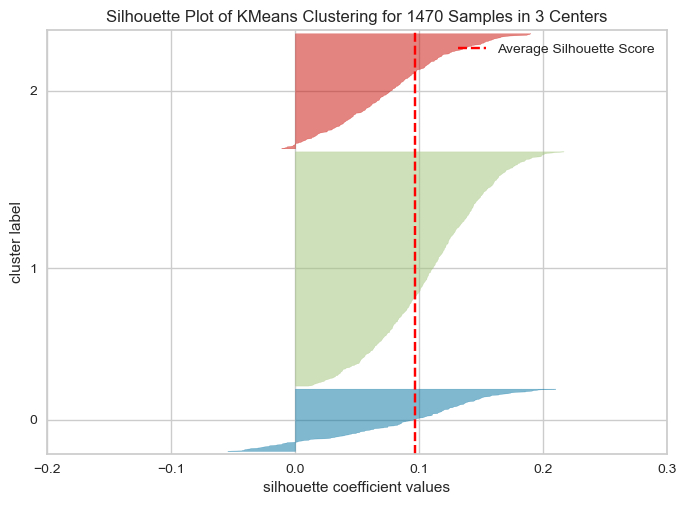



=== Silhouette plot for 4 Clusters ===


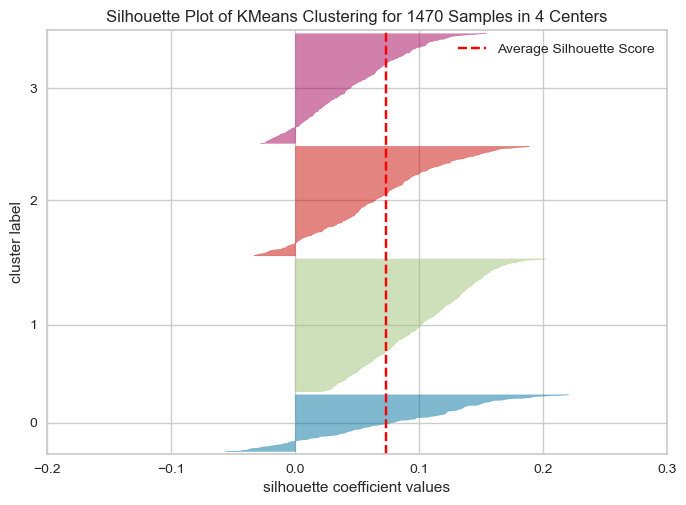



=== Silhouette plot for 5 Clusters ===


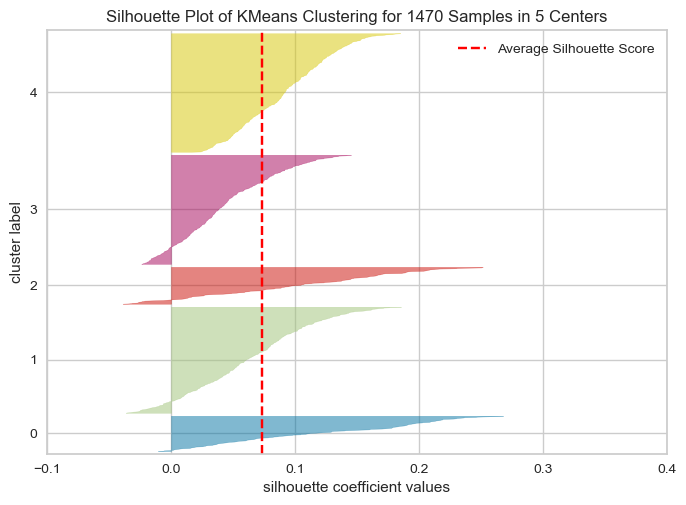



=== Silhouette plot for 6 Clusters ===


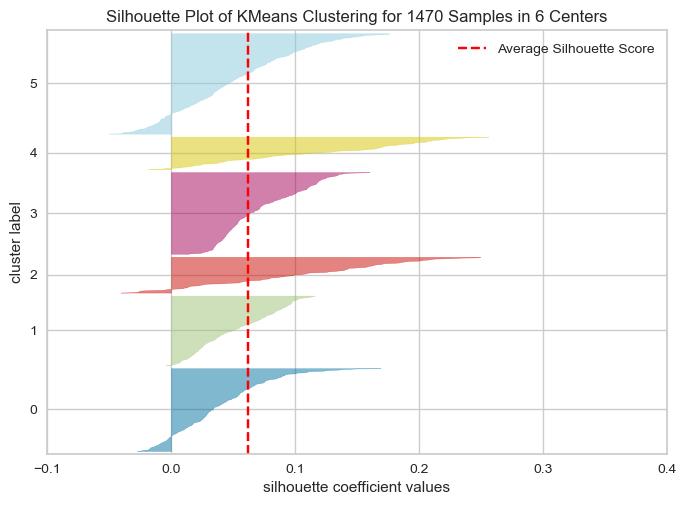



=== Silhouette plot for 7 Clusters ===


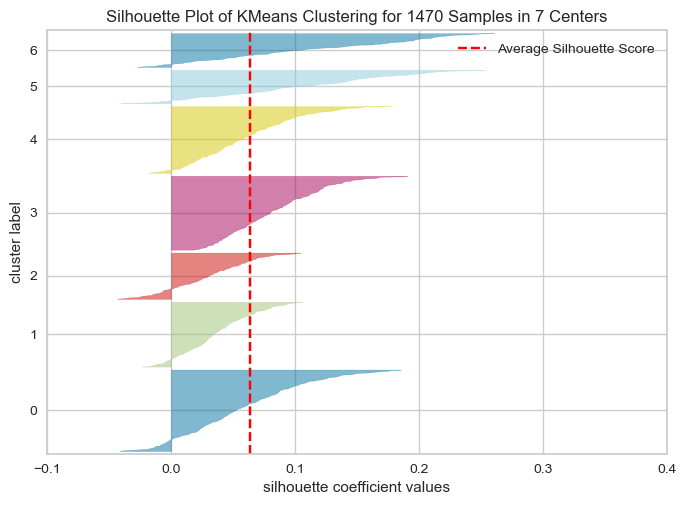



=== Silhouette plot for 8 Clusters ===


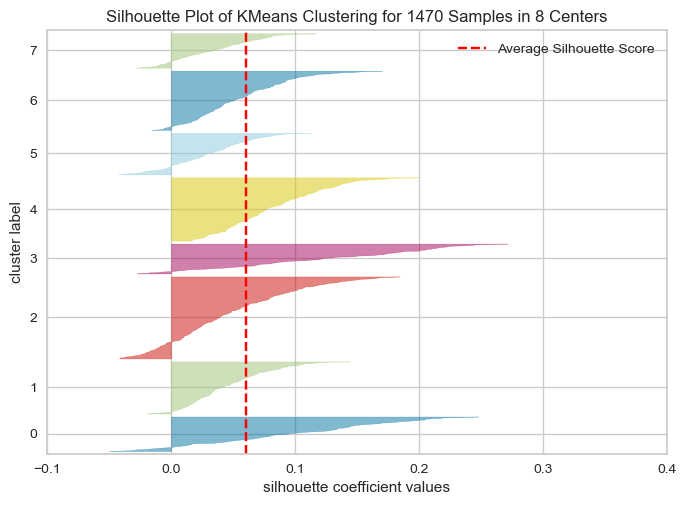



=== Silhouette plot for 9 Clusters ===


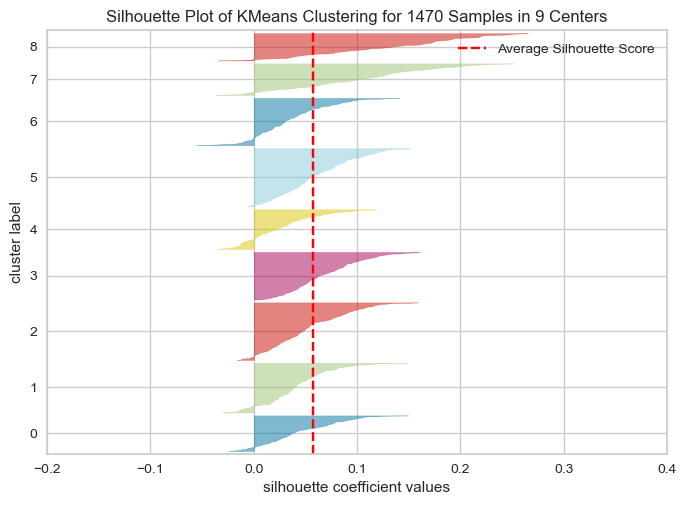



=== Silhouette plot for 10 Clusters ===


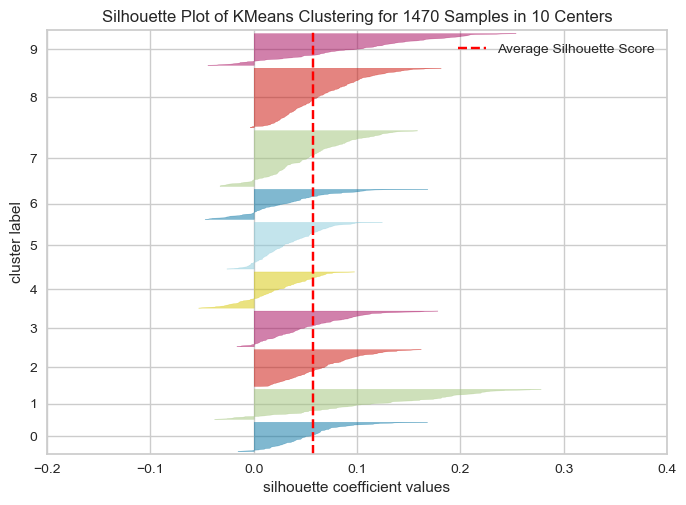

In [38]:
from yellowbrick.cluster import SilhouetteVisualizer

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(2,7), metric='silhouette')
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()
print("\n")

for n_clusters in np.arange(start=2,stop=11):
  
  print(f"=== Silhouette plot for {n_clusters} Clusters ===")
  visualizer = SilhouetteVisualizer(estimator = KMeans(n_clusters=n_clusters, random_state=0),
                                    colors = 'yellowbrick')
  visualizer.fit(df_analysis)
  visualizer.show()
  plt.show()
  print("\n")

#### Elbow gives k = 3, silhouette average gives k= 2, silhouette plot for 3 is best since the Elbow method says K=3, Most points above average silhouette, Better balance than K=2, More interpretable than K=4/5 ✓

In [39]:
# Note: PCA implementation approach adapted from [Code Institute] Apply K-means Clustering
# Original reference: [Data Analysis and AI Bootcamp/2026]
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def PipelineCluster():
      # Binary columns
    binary_cols = ['Attrition', 'Gender', 'OverTime']
    
    # Ordinal columns
    ordinal_cols = [
        'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
        'JobLevel', 'JobSatisfaction', 'PerformanceRating',
        'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
    ]
    
    # Nominal columns
    nominal_cols = [
        'BusinessTravel', 'Department', 'EducationField',
        'JobRole', 'MaritalStatus'
    ]
    
    # Numeric columns
    numeric_cols = [
        'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
        'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'
    ]
    
    # Create transformers for each type
    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    ordinal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Combine all transformers
    preprocessor = ColumnTransformer([
        ('binary', binary_transformer, binary_cols),    # 2 categories
        ('ordinal', ordinal_transformer, ordinal_cols), # Ordered categories
        ('nominal', nominal_transformer, nominal_cols), # Unordered categories
        ('numeric', numeric_transformer, numeric_cols)
    ])
    
    pipeline_base = Pipeline([
        ('preprocessor', preprocessor),  # Changed from 'column_transformer'
        ("PCA", PCA(n_components=21, random_state=0)), 
        ("model", KMeans(n_clusters=3, random_state=0)), 
    ])
    return pipeline_base

PipelineCluster()

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Attrition', 'Gender',
                                                   'OverTime']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Education',
                                                   'EnvironmentSatisfa...
                                                                   StandardScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('PCA', PCA(n_components=21, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

#### Fit Cluster Pipeline

In [40]:
X = df.copy()
print(X.shape)
X.head(3)

(1470, 31)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0


#### Then, we fit the Cluster pipeline to the training data (X)

In [41]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Attrition', 'Gender',
                                                   'OverTime']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Education',
                                                   'EnvironmentSatisfa...
                                                                   StandardScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'HourlyRate',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('PCA', PCA(n_components=21, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

#### Create labels, column called Clusters

In [42]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(1470, 32)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Clusters
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,1,0,8,0,1,6,4,0,5,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,1,10,3,3,10,7,1,7,2
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,2,0,7,3,3,0,0,0,0,1


### 3.3 Descriptive Statistics
#### i) Cluster Frequency

* Clusters frequencies 
          proportion
Clusters            
1               0.57
2               0.28
0               0.15 




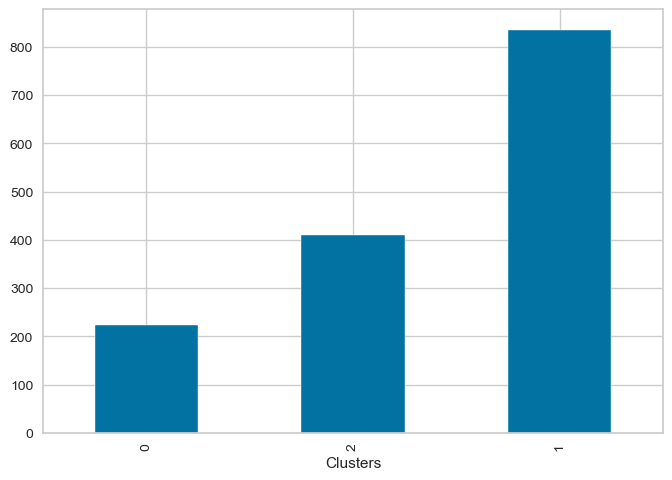

In [43]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

#### ii) Performance evaluation
* Use the created label for evaluation via a classification model

In [44]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(1470, 32)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Clusters
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,1,0,8,0,1,6,4,0,5,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,1,10,3,3,10,7,1,7,2
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,2,0,7,3,3,0,0,0,0,1


#### split train and test sets, where the target variable is 'Clusters'

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1176, 31) (1176,) (294, 31) (294,)


In [52]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel  

def PipelineClf2ExplainClusters():
    # Binary columns
    binary_cols = ['Attrition', 'Gender', 'OverTime']
    
    # Ordinal columns
    ordinal_cols = [
        'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
        'JobLevel', 'JobSatisfaction', 'PerformanceRating',
        'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
    ]
    
    # Nominal columns
    nominal_cols = [
        'BusinessTravel', 'Department', 'EducationField',
        'JobRole', 'MaritalStatus'
    ]
    
    # Numeric columns
    numeric_cols = [
        'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
        'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
        'YearsWithCurrManager'
    ]
    
    # Create transformers
    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    ordinal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])
    
    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Combine all transformers
    preprocessor = ColumnTransformer([
        ('binary', binary_transformer, binary_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('numeric', numeric_transformer, numeric_cols)
    ])
    
    # Create pipeline with feature selection
    pipeline_base = Pipeline([
        ('preprocessor', preprocessor),
    
        ('feat_selection', SelectFromModel(GradientBoostingClassifier(random_state=0))),  
        ('model', GradientBoostingClassifier(random_state=0)), 
    ])
    
    return pipeline_base

# Create pipeline
pipeline = PipelineClf2ExplainClusters()


In [53]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Attrition', 'Gender',
                                                   'OverTime']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Education',
                                                   'EnvironmentSatisfa...
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       671
           2       0.99      1.00      1.00       327

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176



* Accuracy: 1.00 (100%) on 1176 samples
* Perfect classification for all three classes (0, 1, 2)

In [55]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        45
           1       0.98      0.97      0.98       165
           2       0.94      0.98      0.96        84

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294



* Accuracy: 0.97 (97%) on 294 samples
* Class 0: Precision 1.00, Recall 0.98, F1 0.99
* Class 1: Precision 0.98, Recall 0.97, F1 0.98
* Class 2: Precision 0.94, Recall 0.98, F1 0.96

#### Key Observations
* Model is well-trained: Minimal performance gap between sets
* Class 2 has slightly lower precision: More false positives for class 2
* Class 0 is best predicted: Highest precision and nearly perfect recall
* Balanced performance: Weighted and macro averages are very close, indicating balanced performance across classes

#### Recommendations
* The model is production-ready with 97% test accuracy


In [67]:
pipeline_clf_cluster

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Attrition', 'Gender',
                                                   'OverTime']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Education',
                                                   'EnvironmentSatisfa...
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

#### iii) Feature Importance
* Define the columns

In [71]:

# Column definitions

binary_cols = ['Attrition', 'Gender', 'OverTime']

ordinal_cols = [
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
    'JobLevel', 'JobSatisfaction', 'PerformanceRating',
    'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
]

nominal_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'JobRole', 'MaritalStatus'
]

numeric_cols = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
    'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
    'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
    'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]


In [72]:
# Update the pipeline to USE these columns
def PipelineClf2ExplainClusters():
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
    from sklearn.impute import SimpleImputer
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.feature_selection import SelectFromModel

    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])

    ordinal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])

    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer([
        ('binary', binary_transformer, binary_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('numeric', numeric_transformer, numeric_cols)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feat_selection', SelectFromModel(
            GradientBoostingClassifier(random_state=0)
        )),
        ('model', GradientBoostingClassifier(random_state=0))
    ])

    return pipeline


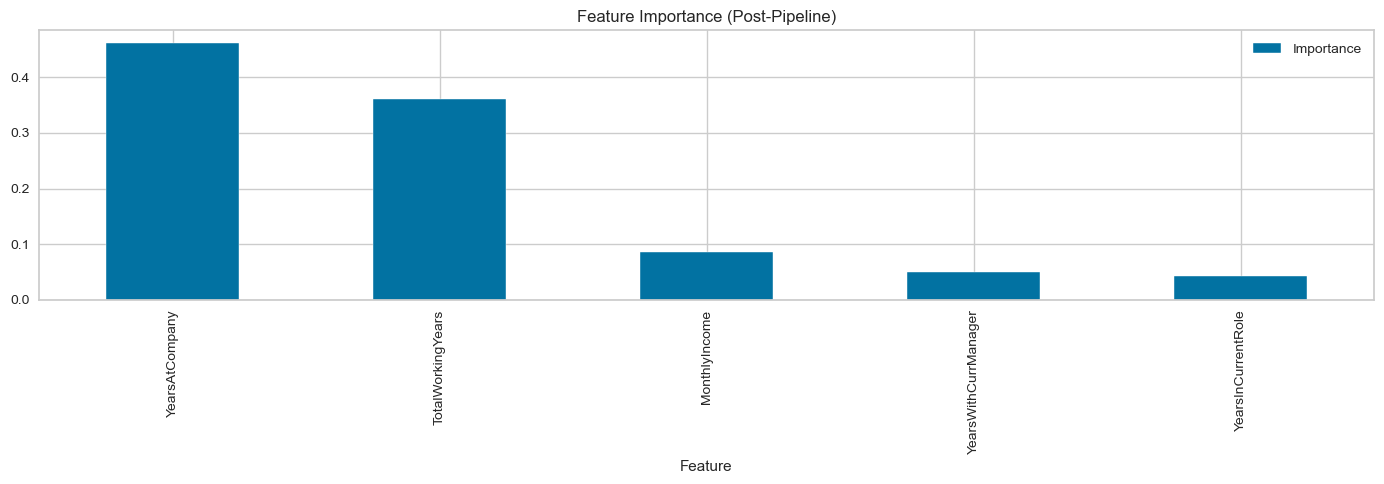

,Feature,Importance
0,YearsAtCompany,0.460932
1,TotalWorkingYears,0.360192
2,MonthlyIncome,0.085259
3,YearsWithCurrManager,0.050519
4,YearsInCurrentRole,0.043097


In [73]:
#Fit and extract importance
pipeline = PipelineClf2ExplainClusters()
pipeline.fit(X_train, y_train)

df_feature_importance = get_feature_importance_from_pipeline(
    pipeline,
    binary_cols,
    ordinal_cols,
    nominal_cols,
    numeric_cols
)

df_feature_importance.head(10)


### Model Persistence
After evaluation to ensure that learned parameters are valid, reproducible, and suitable for deployment, the model is now fit for persistence. This reflects best practice in applied machine learning, where only validated models are promoted beyond the experimental stage.
- Save clustering model in a folder called models 

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def PipelineCluster(n_clusters=3):
    # ----------------------------
    # Feature groups (NO Attrition)
    # ----------------------------

    binary_cols = ['Gender', 'OverTime']

    ordinal_cols = [
        'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
        'JobLevel', 'JobSatisfaction', 'PerformanceRating',
        'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
    ]

    nominal_cols = [
        'BusinessTravel', 'Department', 'EducationField',
        'JobRole', 'MaritalStatus'
    ]

    numeric_cols = [
        'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate',
        'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
        'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager'
    ]

    # Transformers

    binary_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])

    ordinal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder())
    ])

    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False
        ))
    ])

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer([
        ('binary', binary_transformer, binary_cols),
        ('ordinal', ordinal_transformer, ordinal_cols),
        ('nominal', nominal_transformer, nominal_cols),
        ('numeric', numeric_transformer, numeric_cols)
    ])


    # Clustering pipeline

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=21, random_state=0)),
        ('cluster', KMeans(
            n_clusters=3,
            random_state=0,
            n_init=20
        ))
    ])

    return pipeline


In [89]:
import joblib
import os


X_cluster = X.copy()

pipeline_cluster = PipelineCluster(n_clusters=3)
pipeline_cluster.fit(X_cluster)

# Assign cluster labels
X_cluster = X_cluster.copy()
X_cluster["Cluster"] = pipeline_cluster.predict(X_cluster)

# Save model WITH metadata
os.makedirs("models", exist_ok=True)
joblib.dump(
    {
        "pipeline": pipeline_cluster,
        "feature_columns": X_cluster.columns.tolist(),
        "cluster_mapping": {
            0: "Low Risk",
            1: "Moderate Risk",
            2: "High Risk"
        }
    },
    "models/employee_attrition_cluster.pkl"
)


['models/employee_attrition_cluster.pkl']